# Private Sector Travel Time & Congestion Data

1. Private sector data sources
2. Querying data
3. Analyzing data

### Setup

In [165]:
# ! pip install pyarrow

In [166]:
import dask.dataframe as dd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

In [167]:
data_dir = "/Users/robmarty/Dropbox/World Bank/Trainings and Code Resources/LAMATA Workshop 2024/Data"

### Load travel time data

In [168]:
# os.listdir(data_dir + "/Google Travel Time/Final/travel_time_monthly/")

In [169]:
# Travel time
google_tt_dir = data_dir + "/Google Travel Time/Final/travel_time_monthly/"
google_tt_df = dd.read_parquet(google_tt_dir)

### Load routes spatial data

In [170]:
route_file = data_dir + "/Google Travel Time/Final/routes.geojson"
route_gpd = gpd.read_file(route_file)

In [171]:
route_gpd.iloc[[0]].explore()

In [172]:
route_gpd.explore()

# Part 1: Explore data

## Exercise: Examine Data
1. What variables do we have?
2. How many observations are there?
3. How many routes are there (identified by origin & destination lat/lon)
4. What are the start and end dates?

In [173]:
# Look at variables
google_tt_df.head()

datetime name_o name_d route_name     lat_o     lon_o  \
0 2020-03-25 01:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
1 2020-03-25 02:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
2 2020-03-25 03:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
3 2020-03-25 04:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
4 2020-03-25 05:00:04+01:00     O1    O17   o1 - o17  6.458488  3.387256   

      lat_d     lon_d  speed_kmhr_in_traffic_s  duration_in_traffic_s  \
0  6.475177  3.381537                31.046475                  383.0   
1  6.475177  3.381537                24.217515                  491.0   
2  6.475177  3.381537                24.876151                  478.0   
3  6.475177  3.381537                24.772500                  480.0   
4  6.475177  3.381537                23.734132                  501.0   

   distance_m route_opened_date route_suspended_date  
0      3303.0              <NA>                 <NA>  
1      3303.0              <NA>                 <NA>  
2      3303.0              <NA>                 <NA>  
3      3303.0              <NA>                 <NA>  
4      3303.0              <NA>                 <NA>

In [174]:
# Number of observations
google_tt_df.shape[0].compute()

31663318

In [175]:
# Number of routes
od_df = google_tt_df.groupby(["lat_o", "lon_o", "lat_d", "lon_d"]).size().compute()
od_df.shape

(447,)

# Part 2: Speed over time

## Exercise: Take average speed within each day; plot trends over time

<Axes: xlabel='date', ylabel='speed_kmhr_in_traffic_s'>

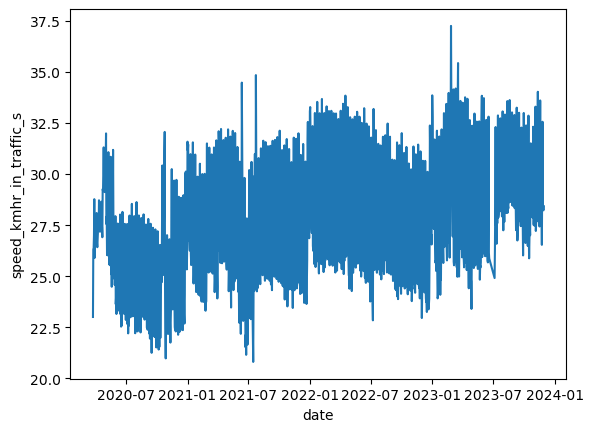

In [176]:
google_tt_df['date'] = google_tt_df['datetime'].dt.date

day_df = google_tt_df.\
    groupby('date').\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute()

sns.lineplot(data=day_df, x='date', y='speed_kmhr_in_traffic_s')

### Exercise: Take average speed within each week; plot trends over time

<Axes: xlabel='week', ylabel='speed_kmhr_in_traffic_s'>

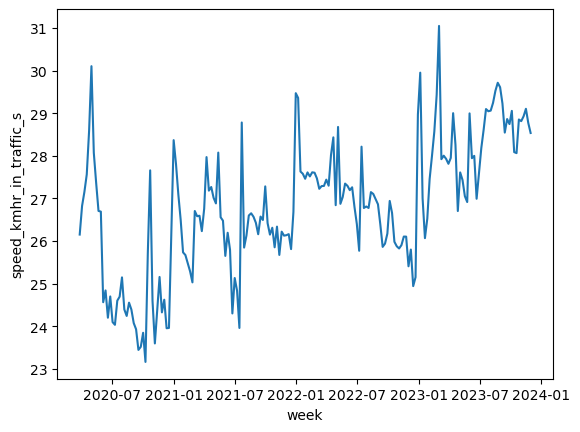

In [177]:
# Define a function to round dates to the nearest week
def round_to_nearest_week(df):
    df['week'] = df['datetime'].dt.round('7D')
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_df = google_tt_df.map_partitions(round_to_nearest_week)

week_df = google_tt_df.\
    groupby('week').\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute()

sns.lineplot(data=week_df, x='week', y='speed_kmhr_in_traffic_s')

### Exercise: Take average speed by hour of day, plot speeds by hour of day

<Axes: xlabel='hour', ylabel='speed_kmhr_in_traffic_s'>

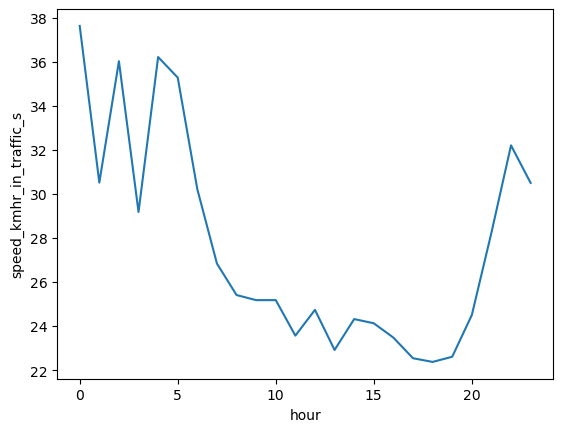

In [178]:
# Define a function to add hour variable
def determine_hour(df):
    df['hour'] = df['datetime'].dt.hour
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_df = google_tt_df.map_partitions(determine_hour)

hour_df = google_tt_df.\
    groupby('hour').\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute()

sns.lineplot(data=hour_df, x='hour', y='speed_kmhr_in_traffic_s')

### Exercise: Take average speed by hour of day AND day of week. Create a figure that plots hour of day for each day of week.

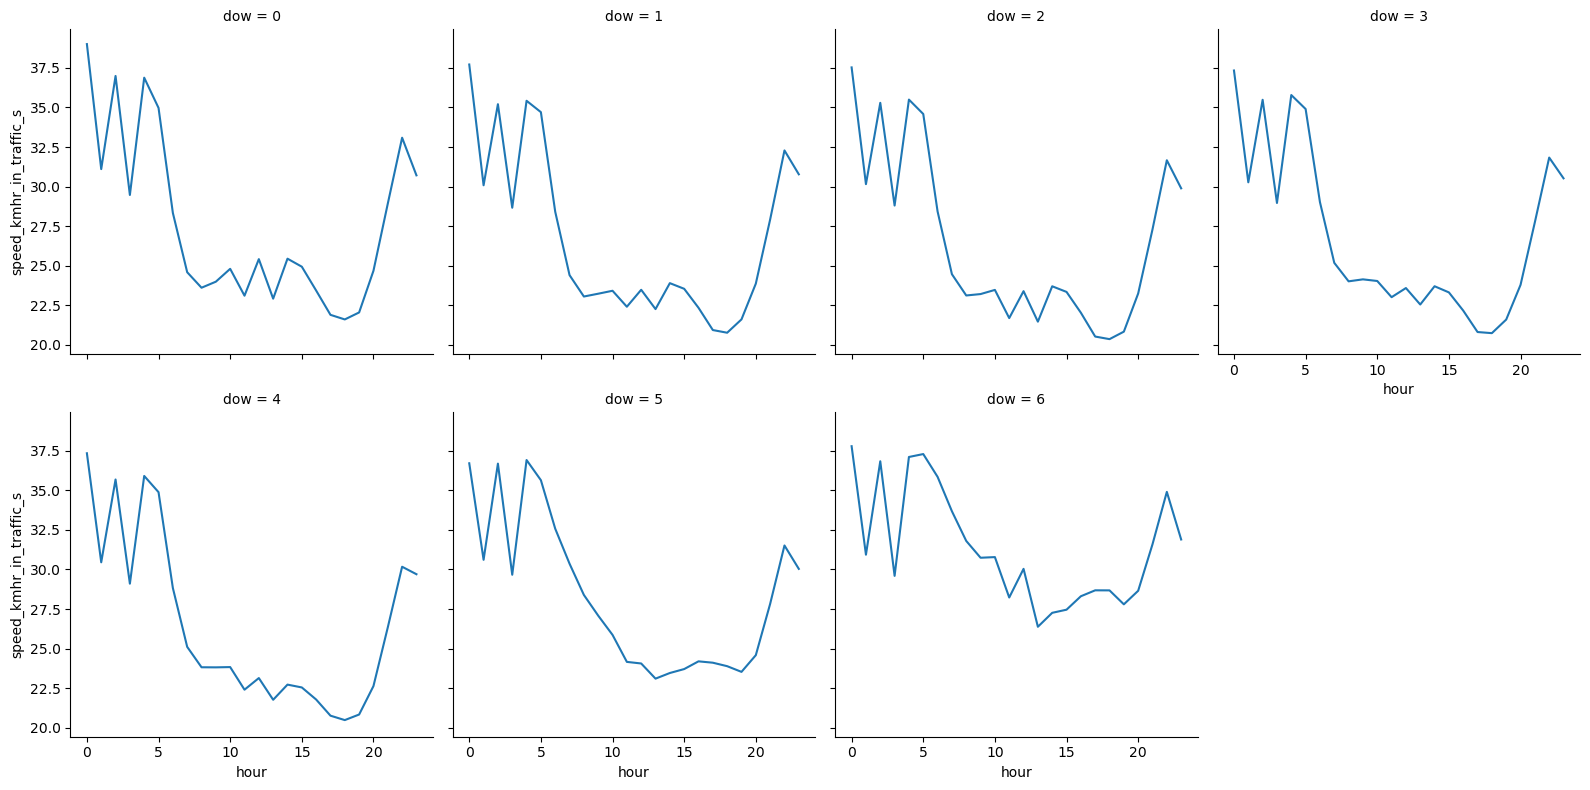

In [179]:
# Define a function to add hour and day of week variable
def determine_hour_dow(df):
    df['hour'] = df['datetime'].dt.hour
    df['dow'] = df['datetime'].dt.dayofweek
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_df = google_tt_df.map_partitions(determine_hour_dow)

hour_dow_df = google_tt_df.\
    groupby(['hour', 'dow']).\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute().\
    reset_index()

g = sns.FacetGrid(hour_dow_df, col='dow', col_wrap=4, height=4, aspect=1)
g.map(sns.lineplot, 'hour', 'speed_kmhr_in_traffic_s')

### Exercise: Take average speed by hour of day for each year, make a figure plotting speeds by hour of day for each year

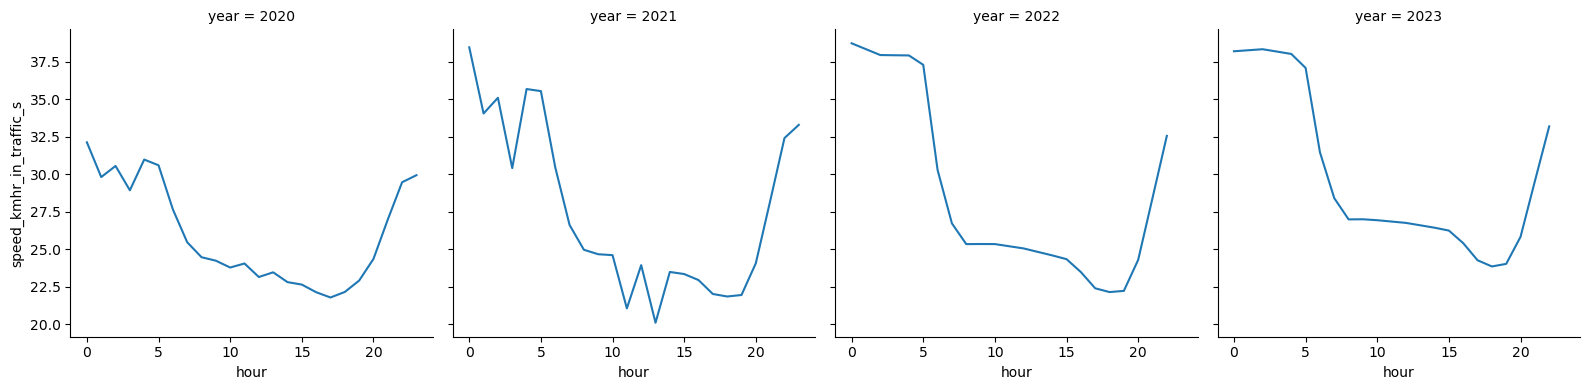

In [180]:
# Define a function to add hour and day of week variable
def determine_hour_year(df):
    df['hour'] = df['datetime'].dt.hour
    df['year'] = df['datetime'].dt.year
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_df = google_tt_df.map_partitions(determine_hour_year)

hour_year_df = google_tt_df.\
    groupby(['hour', 'year']).\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute().\
    reset_index()

g = sns.FacetGrid(hour_year_df, col='year', col_wrap=4, height=4, aspect=1)
g.map(sns.lineplot, 'hour', 'speed_kmhr_in_traffic_s')

### Exercise: Compare average speed between BRT routes and non-BRT routes

In [181]:
google_tt_df.head()

datetime name_o name_d route_name     lat_o     lon_o  \
0 2020-03-25 01:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
1 2020-03-25 02:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
2 2020-03-25 03:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
3 2020-03-25 04:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
4 2020-03-25 05:00:04+01:00     O1    O17   o1 - o17  6.458488  3.387256   

      lat_d     lon_d  speed_kmhr_in_traffic_s  duration_in_traffic_s  \
0  6.475177  3.381537                31.046475                  383.0   
1  6.475177  3.381537                24.217515                  491.0   
2  6.475177  3.381537                24.876151                  478.0   
3  6.475177  3.381537                24.772500                  480.0   
4  6.475177  3.381537                23.734132                  501.0   

   distance_m route_opened_date route_suspended_date        date  \
0      3303.0              <NA>                 <NA>  2020-03-25   
1      3303.0              <NA>                 <NA>  2020-03-25   
2      3303.0              <NA>                 <NA>  2020-03-25   
3      3303.0              <NA>                 <NA>  2020-03-25   
4      3303.0              <NA>                 <NA>  2020-03-25   

                       week  hour  dow  year  
0 2020-03-26 00:00:00+01:00     1    2  2020  
1 2020-03-26 00:00:00+01:00     2    2  2020  
2 2020-03-26 00:00:00+01:00     3    2  2020  
3 2020-03-26 00:00:00+01:00     4    2  2020  
4 2020-03-26 00:00:00+01:00     5    2  2020

### Exercise: Determine the distance from each route to Ikeja BRT terminal. Compare average speed between routes within 5 kilometers of Ikeja BRT terminal and other routes.

In [195]:
# Make GeoDataFrame of Ikeja Bus Terminal

# Make pandas dataframe
ikeja_df = pd.DataFrame(
    {
        "Name": ["Ikeja"],
        "Latitude": [6.5919],
        "Longitude": [3.3392],
    }
)

# Convert to geopandas dataframe
ikeja_gdf = gpd.GeoDataFrame(
    ikeja_df, geometry=gpd.points_from_xy(ikeja_df.Longitude, ikeja_df.Latitude), crs="EPSG:4326"
)

In [183]:
# Project to UTM; units are now in meters
utm_epsg_code = "32631"
ikeja_gdf_utm = ikeja_gdf.to_crs(epsg=utm_epsg_code)
route_gpd_utm = route_gpd.to_crs(epsg=utm_epsg_code)

In [184]:
# Determine which routes are within 5km of Ikeja

## Grab shapely geometry
ikeja_point = ikeja_gdf_utm.geometry.iloc[0]

## Calculate the distance
route_gpd['distance_to_ikeja'] = route_gpd_utm.geometry.distance(ikeja_gdf_utm)
route_gpd['5km_to_ikeja'] = route_gpd['distance_to_ikeja'] <= 5000

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_42751/322931937.py:7: UserWarning: The indices of the two GeoSeries are different.
  route_gpd['distance_to_ikeja'] = route_gpd_utm.geometry.distance(ikeja_gdf_utm)


In [185]:
# Define a function to add hour and day of week variable
def merge_route(df):
    df = df.merge(route_gpd, on = ["lat_o", "lon_o", "lat_d", "lon_d"], how = "left")
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_route_df = google_tt_df.map_partitions(merge_route)

In [192]:
google_tt_route_df['speed_kmhr_in_traffic_s'][google_tt_route_df['5km_to_ikeja'] == True].\
    describe().\
    compute()

count    60476.000000
mean        23.744511
std          8.706372
min          7.103670
25%         19.180544
50%         24.329927
75%         34.993511
max         56.605198
Name: speed_kmhr_in_traffic_s, dtype: float64

In [193]:
google_tt_route_df['speed_kmhr_in_traffic_s'][google_tt_route_df['5km_to_ikeja'] == False].\
    describe().\
    compute()

count    5.715596e+07
mean     2.627108e+01
std      1.135796e+01
min      1.915756e+00
25%      2.123642e+01
50%      2.689684e+01
75%      3.439073e+01
max      9.286829e+01
Name: speed_kmhr_in_traffic_s, dtype: float64

# Part 3: Speed by location

### Exercise: Take average speed by route and plot histogram of speeds

__Hint:__ Routes are determined by origin/destination latitude and longitude

<Axes: xlabel='speed_kmhr_in_traffic_s', ylabel='Count'>

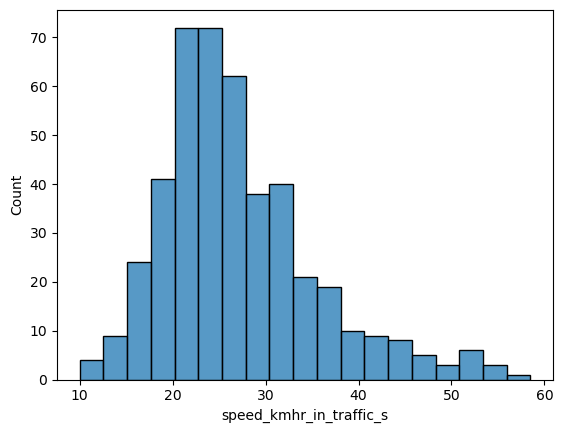

In [186]:
route_df = google_tt_df.\
    groupby(['lat_o', 'lon_o', 'lat_d', 'lon_d']).\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute().\
    reset_index()

sns.histplot(data = route_df, x = "speed_kmhr_in_traffic_s")

### Exercise: Take average speed by route, merge speeds with route, and make a map of speeds

In [187]:
route_speed_gpd = route_gpd.merge(route_df, 
                                  on = ['lat_o', 'lon_o', 'lat_d', 'lon_d'],
                                  how = 'left')

In [188]:
route_speed_gpd.explore(column = "speed_kmhr_in_traffic_s")